In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import random
import numpy as np

Segmentation Models: using `tf.keras` framework.


In [2]:
heigh = 256

In [3]:
#get name of image to find mask for it
def get_mask(image):
   return tf.strings.split(image,os.path.sep)[-1]

#load images and masks from path
def process_image_with_mask(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   mask = maskspath + get_mask(file_path)
   mask = tf.io.read_file(mask)
   mask = tf.image.decode_png(mask)
   cond = tf.greater_equal(mask,1)
   mask = tf.where(cond,1,0)
   return img,mask

#load images without masks from path
def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   print(img)
   img = tf.image.resize(img, (heigh, heigh), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   return img

#resize to heigh
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (heigh, heigh), method="nearest")
   input_mask = tf.image.resize(input_mask, (heigh, heigh), method="nearest")
   return input_image, input_mask

#augmentation 1
def flip_leftright(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

#augmentation 2
def flip_updown(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

#augmentation 3
def rotation(input_image, input_mask):
   input_image = tf.image.rot90(input_image)
   input_mask = tf.image.rot90(input_mask)
   return input_image, input_mask

#augmentation 4
def crop(input_image, input_mask):
   seed = random.random()*10000
   input_image = tf.image.random_crop(input_image,size = (heigh*8,heigh*8,3),seed=int(seed))
   input_mask = tf.image.random_crop(input_mask,size = (heigh*8,heigh*8,1),seed=int(seed))
   return input_image, input_mask

def adjust_brightness(input_image, input_mask):
   input_image = tf.image.adjust_brightness(input_image,delta=0.1)
   return input_image, input_mask

def adjust_gamma(input_image, input_mask):
   input_image = tf.image.adjust_gamma(input_image)
   return input_image, input_mask

#normalize mask and image
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.float32)
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(flip_leftright)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(flip_updown)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(adjust_gamma)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(adjust_brightness)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(crop)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
      dataset = dataset.shuffle(64)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [4]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [5]:
BACKBONE = 'resnet34'

In [6]:
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [7]:
path = 'castom-masks/val/'
valimagepath = path + 'img/*'
maskspath = path + 'masks_machine/'

valdata = tf_dataset(valimagepath,learning = True)
valdata = valdata.batch(4)

In [8]:
path = 'castom-masks/train/'
trainimagepath = path + 'img/*'
maskspath = path + 'masks_machine/'

data = tf_dataset(trainimagepath,learning = True)

In [9]:
# fit model
model.fit(
    data.batch(4),
    epochs=10,
    validation_data=valdata,
)

Epoch 1/10
136/136 [==============================] - 214s 2s/step - loss: 0.7292 - iou_score: 0.3168 - val_loss: 104.7256 - val_iou_score: 2.0009e-04
Epoch 2/10
136/136 [==============================] - 203s 1s/step - loss: 0.4185 - iou_score: 0.6007 - val_loss: 1.1800 - val_iou_score: 4.6086e-05
Epoch 3/10
136/136 [==============================] - 209s 2s/step - loss: 0.4038 - iou_score: 0.6172 - val_loss: 1.1923 - val_iou_score: 2.1866e-05
Epoch 4/10
136/136 [==============================] - 209s 2s/step - loss: 0.3429 - iou_score: 0.6757 - val_loss: 1.2190 - val_iou_score: 5.3729e-06
Epoch 5/10
136/136 [==============================] - 203s 1s/step - loss: 0.3245 - iou_score: 0.6932 - val_loss: 1.2127 - val_iou_score: 9.2096e-06
Epoch 6/10
136/136 [==============================] - 204s 1s/step - loss: 0.3267 - iou_score: 0.6913 - val_loss: 1.1979 - val_iou_score: 0.0017
Epoch 7/10
136/136 [==============================] - 217s 2s/step - loss: 0.3057 - iou_score: 0.7111 - val_

In [10]:
test = tf_dataset('cropped/AAE_0133.png',learning=False)
pred_mask = model.predict(test)

Tensor("DecodePng:0", shape=(None, None, None), dtype=uint8)
1/1 [==============================] - 1s 704ms/step


In [12]:
from matplotlib import pyplot as plt

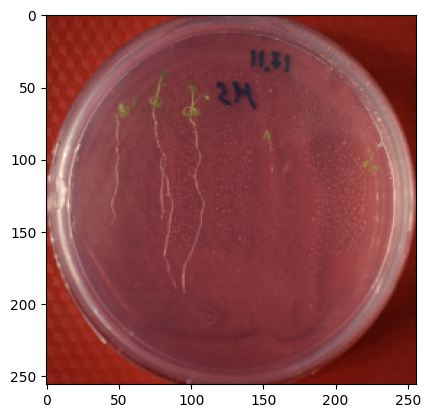

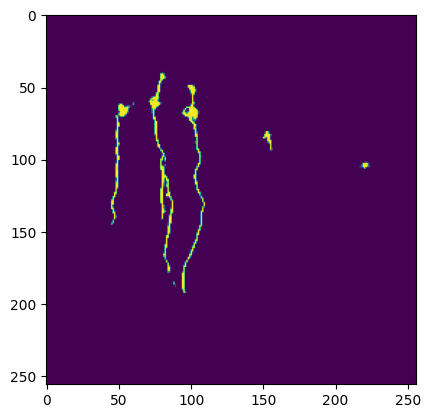

In [13]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])